In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import daft
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation
from simulate_strategy import simulate_strategy

In [3]:
def get_pgm():
    y = 1 
    pgm = daft.PGM()
    pgm.add_node("p", r"$p$", 0, y, fixed=True, offset=(1, 3))
    pgm.add_node("L", r"$L$", 1, y)
    pgm.add_node("theta", r"$\theta$", 2, y)
    pgm.add_node("H_n", r"$H_n$", 3, y, observed=True)
    pgm.add_edge("p", "L")
    pgm.add_edge("L", "theta")
    pgm.add_edge("theta", "H_n")
    pgm.add_plate([2.5, 0.5, 1, 1], label=r"$n = 1:N$", shift=-0.2)
    return pgm.render()

### Strategy: make use of Bayesian inference.
This strategy uses Bayesian inference to determine the best strategy to play if we do not know either to probability of what kind of oppenent we get and if we do not know with the probability of the skwed coin.

The following wikipedia pages were used as reference 
[Checking whether a coin is fair](https://en.wikipedia.org/wiki/Checking_whether_a_coin_is_fair) and [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).

The following code shows the probabilitic graphical model for the coin flip distribution.

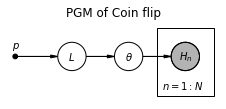

In [4]:
get_pgm().set_title("PGM of Coin flip");


- $p$: The probability of the opponent being fair.
- $L$:  Bernouilli distribution with unkown parameter p. Determines if the opponent is a cheater or not.
- $\theta$: Unkown distribution with values $\in [0, 1]$. Gives parameters of the Bernoulli distribution of H.
- $H_{1:N}$: Bernouilli distribution with parameter $\theta$ and $N$ samples. Gives the number of heads.

We use Bayes rule to get:
$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N}, \theta | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | \theta, L) \cdot P(\theta | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | \theta) \cdot P(\theta | L) \cdot P(L)}{P(H_{1:N})} \\
               &\propto \sum_{\theta=0}^1 P(H_{1:N} | \theta) \cdot P(\theta | L) \cdot P(L) \\
\end{align*}
$$

After choosing the label, we get to know the true Label L.
We can then update the priors $P(\theta | L)$ and $P(L)$

$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(H_{})}{P(H_{1:N} | L)} \\
&= \frac{P(H_{1:N} | \theta) \cdot P(\theta | L)}{P(H_{1:N} | L)} \\
&\propto P(H_{1:N} | \theta) \cdot P(\theta | L)
\end{align*}
$$

$$
\begin{align*}
P(\theta | L, H_{1:N}) &= \frac{P(H_{1:N} | \theta, L) \cdot P(\theta | L)}{P(H_{1:N} | L)} \\
&= \frac{P(H_{1:N} | \theta) \cdot P(\theta | L)}{P(H_{1:N} | L)} \\
&\propto P(H_{1:N} | \theta) \cdot P(\theta | L)
\end{align*}
$$

In [5]:
class StrategyBayseianInference:

    def __init__(self, 
                 n = 101, 
                 threshold = 0.75, 
                 flip_5_at_start = False):
        assert 0 <= threshold <= 1
        # n is the number of theta values.
        # the threshold is the theshold to use when deciding the label.
        self.threshold = threshold 
        self.theta = np.linspace(0, 1, n)

        # we intitatie theta_L as square functions.
        self.theta_L = np.zeros((n, 2))
        self.theta_L[self.theta > 0.5, 1] = 1
        self.theta_L[(0.45 < self.theta)&(self.theta < 0.55), 0] = 1
        self.theta_L /= self.theta_L.sum(axis=0)
        
        # probability of label 0: fair
        self.observed_L = [0, 1]
        self.p = np.mean(self.observed_L)

        self.last_flips_left = 0
        self.last_n_heads = 0
        self.last_n_tails = 0
        self.last_action = 0
        self.last_label = None
        self.flip_5_at_start = flip_5_at_start

    def set_theshold(self, threshold):
        assert 0 <= threshold <= 1
        self.threshold = threshold

    def update(self, reward=None, flips_left=None):  
        if self.last_label is None:
            return
        if reward is not None:
            self.get_correct_label(reward)
        elif flips_left is not None:
            flips_left_diff = flips_left - self.last_flips_left
            self.get_correct_label(flips_left_diff)
        else:
            raise ValueError("Either reward or flips_left must be given.")
        
        self.last_label = None
        c_label = self.last_correct_label

        # estimate p once again
        self.observed_L.append(c_label)
        self.p = np.mean(self.observed_L)

        # update theta_L using bayesian inference
        self.theta_L[:, c_label] = self.probability_of_observation * self.theta_L[:, c_label]
        self.theta_L /= self.theta_L.sum(axis=0)
    
    def get_correct_label(self, reward):
        if reward == 15:
            correct_label = True
        elif reward == -30:
            correct_label = False
        else:
            raise ValueError(f"Reward {reward} is not 15 or -30.")
        
        if correct_label:
            self.last_correct_label = self.last_label
        else:
            self.last_correct_label = (self.last_label + 1) % 2


    def strategy(self, n_heads, n_tails, flips_left):
        self.last_flips_left = flips_left

        if self.flip_5_at_start and n_heads + n_tails == 0 and flips_left >= 5:
            return 1
        
        theta = self.theta
        self.probability_of_observation = theta ** n_heads * (1 - theta) ** n_tails

        posterior = self.probability_of_observation.dot(self.theta_L) * np.array([self.p, 1 - self.p])
        posterior /= np.sum(posterior)

        

        if np.max(posterior) > self.threshold or flips_left == 0:
            label = np.argmax(posterior)
            self.last_label = label
            return label + 2
        else:
            return 0

In [24]:
strat = StrategyBayseianInference(n=101)
g = CoinGameSimulation()
scores = []

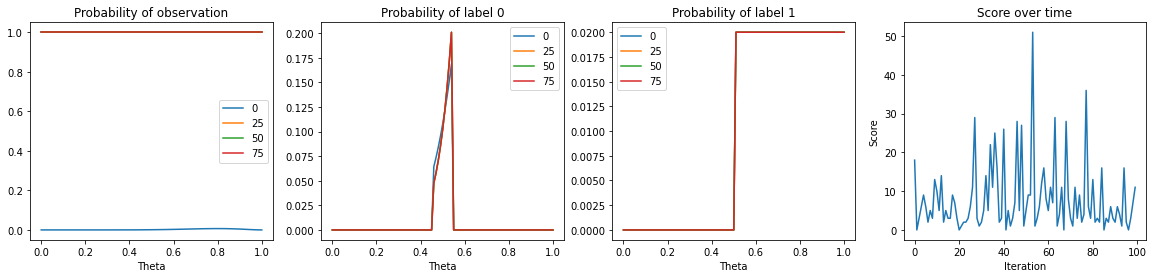

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)
    strat.update(reward=reward)

    scores.append(info["score"])
    if i % 25 == 0:
        clear_output(wait=True)
        ax[0].plot(strat.theta, strat.probability_of_observation.copy(), label=i)
        ax[1].plot(strat.theta, strat.theta_L[:, 0].copy(), label=i)
        ax[2].plot(strat.theta, strat.theta_L[:, 1].copy(), label=i)
ax[3].plot(scores)
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("Score")
ax[3].set_title("Score over time")

for i, title in enumerate(["Probability of observation", "Probability of label 0", "Probability of label 1"]):
    ax[i].legend()
    ax[i].set_title(title)
    ax[i].set_xlabel("Theta")

In [8]:
strat.set_theshold(0.70)
simulate_strategy(strat.strategy, n_simulations=500)

Score           mean: 149.89, std: 359.83, median  37, min:   0, max: 4436
Labels per game mean: 200.98, std: 474.81, median  52, min:   3, max: 5853
Flips per game  mean: 829.96, std: 1949.38, median 235, min:  10, max: 24138
Flips per label mean:  4.13, std:  4.49, median   2, min:   0, max: 142
Reward          mean: -0.11, std:  8.84, median  -1, min: -30, max:  15
Accuracy: 0.746, Precision: 0.695, Recall: 0.773, F1-score: 0.732
